In [1]:
import torchvision.datasets as dset
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
from pycocotools.coco import COCO
import json
import os

## Preprocess Data

In [2]:
path2data_val="../data/processed/img"
path2json_val="../data/processed/ann.json"

### Modifying Torch's CocoDetection
First, we create an object that will help us parse our annotations. It is based off of the CocoDetection class. Since our created data file (ann.json) consists of tuples with an image path and a category, we mainly just had to modify the retrieval of the image and simplified the original CocoDetection. 

In [3]:
class Detect(data.Dataset):
    def __init__(self, root, annFile, transform=None, target_transform=None):
        """
        ::root:: path to image directory
        ::annFile:: path to annotations file
        ::transform:: function to transform annotation file
        ::target_transform:: function to transform targets
        """
        self.root = root
        with open(annFile) as jsonfile:
            self.ann = json.loads(jsonfile.read())
        self.transform = transform
        self.target_transform = target_transform
        self.ids = len(self.ann)

    def __getitem__(self, index):
        ann = self.ann
        target = ann[index][1]

        path = ann[index][0]

        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self):
        return self.ids

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

### Tranforming our dataset
Then, we enter our data in. Because the original training set extremely large, we will be using the validation set; after preprocessing our dataset, we actually have a large dataset despite only using the validation data (with around 40k entries). We will be transforming our input data by making each image the same size and into tensors.

In [4]:
transform = transforms.Compose(
    [transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
coco_val = Detect(root = path2data_val,
                                annFile = path2json_val,
                  transform=transform

                             )

DataLoader inputs or detection object and allows us to iterate through it.

In [5]:
valloader = torch.utils.data.DataLoader(coco_val, batch_size=4,
                                          shuffle=True, num_workers=2)

### Visualize Dataset
Next, we will visualize some of our data with their original labels.

In [6]:
path2json_val="../data/raw/val_ann.json"

coco = COCO(path2json_val)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


In [7]:
ids = [d["id"] for d in cats]

In [8]:
classes = {}
for d in cats:
    classes[d["id"]] = d["name"]

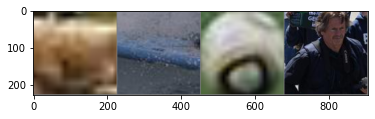

sheep surfboard sports ball person


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(valloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j].item()] for j in range(4)))

## CNN

### Building CNN
Now, we will set up our CNN. First, we create a Net class that defines our neural network. Below, you can see that we are creating a feed-forward convolutional neural network with three linear layers. The forward refers to how the network will "feed" outputs to consecutive layers.

In [10]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        #sqrt
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 91)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training CNN
After setting up our CNN, we will train it with one epoch. We mainly chose one epoch because we were having difficulty training more without either our kernal crashing, the pod disconnecting, or the VPN disconnecting. With the saved model, we can continue to train later, however, for the sake of this demo we will be starting with randomized weights and only training once. This model may take hours to run, as with our stochastic gradient descent optimizer we are looping through every training sample.

In [13]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(valloader, 1):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 3.449
[1,  4000] loss: 3.334
[1,  6000] loss: 3.301
[1,  8000] loss: 3.277
Finished Training


### Saving Results
After the CNN is done training, we will save the model in our results folder. By doing this, we can resume training our model at a different time.

In [14]:
PATH = '../results/cifar_net_demo.pth'
torch.save(net.state_dict(), PATH)

### Visualizing a few images and results
We can visualize a few of the outputs. First, we'll start with the ground truth (true labels) and then we'll move on to the predicted labels.

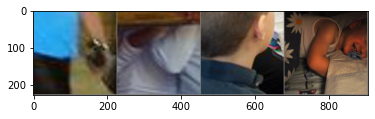

GroundTruth:  person person person person


In [29]:
dataiter = iter(valloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j].item()] for j in range(4)))

We then load the saved model.

In [30]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [31]:
outputs = net(images)

The following is what our model predicted for the images above.

In [32]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j].item()]
                              for j in range(4)))

Predicted:  person person person person


## Evaluating Model

In order to evaluate the model, we calculated the accuracy, which determines the number of correct predictions.

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network: %d %%' % (
    100 * correct / total))

Accuracy of the network: 30 %
